# AB Test Course - PA James 

## 0.1 Imports

In [121]:
import pandas as pd
import math
from statsmodels.stats import api as sms
import numpy as np
import seaborn as sns
from scipy.stats import ttest_1samp, shapiro, ttest_ind, mannwhitneyu, f_oneway, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1.0 Load data

In [99]:
df_raw = pd.read_csv('../datasets/ab_data.csv')

In [100]:
df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# 2.0 Design de Experimentos

## 2.1 Formulação da Hipóteses

In [101]:
#H0: A conversão da nova pagina é de 13%
#H1: A conversão da nova pagina é diferente de 13%

## 2.2 Parâmetros do Experimento

In [102]:
#Nivel de confiança
confidence_level = 0.95

#Nivel de significancia 
significance_level = 0.05

#Conversoes da pagina atual e da nova pagina(esperado pelo time de negocio)
p1=0.13
p2=0.15

# tamanho do efeito
effect_size = sms.proportion_effectsize(p1,p2)

#Power estatistico (erro de oportunidade)
power = 0.8


In [103]:
#sample size
sample_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=power,
    alpha=significance_level)

sample_n = math.ceil(sample_n)
sample_n

4720

In [104]:
print('O tamanho total da amostra {}'.format(2*sample_n))
print('O tamanho da amostra do grupo controle é de {}'.format(sample_n))
print('O tamanho da amostra do grupo de tratamento é de {}'.format(sample_n))


O tamanho total da amostra 9440
O tamanho da amostra do grupo controle é de 4720
O tamanho da amostra do grupo de tratamento é de 4720


In [105]:
conversion_rate = 0.10 #quantas vão abrir/responder
x= sample_n / conversion_rate
print('o numero de email para enviar:{}'.format(int(x)))
print('o numero total da base de emial para enviar:{}'.format(2*int(x)))


o numero de email para enviar:47200
o numero total da base de emial para enviar:94400


In [106]:
#Total de pessoas para o estudo com esse parametos são muito alto.
#Podemos aumentar as porcentagem de converções o que não seria ideal, 
#pois uma diferença da p de tratmento deve ser o menor possivel, 
#assim não tendo diferença na aleatoriedade.


## 2.3 Analises descritivas dos dados

In [107]:
print('Number of rows: {}'.format(df_raw.shape[0]))
print('Number of cols: {}'.format(df_raw.shape[1]))

Number of rows: 294478
Number of cols: 5


### 2.3.1 Verificação de dados faltantes

In [108]:
df_raw.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 2.3.2 Conferir as "flags" do teste A

In [109]:
df_raw[['user_id','group','landing_page']].groupby(['group','landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


In [110]:
df_raw_delete = df_raw[['user_id','group']].groupby(['user_id']).count().reset_index().query('group > 1 ')['user_id']
df1 = df_raw[~df_raw['user_id'].isin(df_raw_delete)]
df1.shape

(286690, 5)

In [111]:
df1[['user_id','group','landing_page']].groupby(['group','landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,old_page,143293
1,treatment,new_page,143397


### 2.3.3 Amonstragem aleatoria dos grupos Controle e Tratamento 

In [112]:
#Contral Group
df_control_sample = df1[df1['group'] == 'control'].sample(n=sample_n, random_state=42)
print('Size of Control Group: {}'.format(df_control_sample.shape[0]))


#Treatment Group
df_treatment_sample = df1[df1['group'] == 'treatment'].sample(n=sample_n, random_state=42)
print('Size of Treatment Group: {}'.format(df_treatment_sample.shape[0]))

#Total Sample Size
df_ab = pd.concat([df_control_sample, df_treatment_sample]).reset_index(drop=True)
df_ab.head()

Size of Control Group: 4720
Size of Treatment Group: 4720


,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0


### 2.3.4 Calculo de métrica de interesse entre os Grupos ( Conversao de cada pagina )

In [114]:
# Control Group
sales = df_control_sample.loc[df_control_sample['converted'] == 1, 'converted'].sum()
visit = len(df_control_sample)

conversion_rate_control = sales/visit
print('Converstion Rate - Control Group: {}'.format(conversion_rate_control))

#Treatment Group
sales = df_treatment_sample.loc[df_treatment_sample['converted'] == 1, 'converted'].sum()
visit = len(df_treatment_sample)

conversion_rate_treatment = sales/visit
print('Converstion Rate - Treatment Group: {}'.format(conversion_rate_treatment))



Converstion Rate - Control Group: 0.11546610169491525
Converstion Rate - Treatment Group: 0.12902542372881357


# 3.0 Teste de hipóteses

In [120]:
df_table = df_ab[['group','converted']].groupby('group').agg({'converted':['sum','count']})
df_table.columns = ['converted','non_converted']
df_table.reset_index()

,group,converted,non_converted
0,control,545,4720
1,treatment,609,4720


In [123]:
chi_val, pval, dof, expected = chi2_contingency(df_table)
print('p-value: {}'.format(pval))

p-value: 0.08059188499562367


In [127]:
if pval < significance_level:
    print('Rejeito a hipotese nula')
else:
    print('Falha em rejeitar a hipotese nula(Aceita a hipotese nula)') 

Falha em rejeitar a hipotese nula(Aceita a hipotese nula)


In [ ]:
# Não consegui concluir que o novo designer não é melhor que a pagina atual,
# Alternativas mudar o designer ou coletar mais amostras

# 4.0 Conversão da paginas em faturamento

In [130]:
df2 = df1.copy()

In [131]:
paginas_atual= 0.13
pagina_nova = 0.15

In [132]:
#compradores = numeros de visitantes * 0.13 
#Gross Margin Value(faturamento) = compradores * 4500

In [134]:
#tranformando as datas
df2['timestamp'] = pd.to_datetime(df2['timestamp']). apply (lambda x: x.strftime('%Y-%m-%d'))

In [170]:
df3 = df2[['user_id','timestamp']].groupby('timestamp').count().reset_index()

#Current GMV
df3['current_purchases'] = np.ceil (df3['user_id'] * 0.13).astype(int)
df3['current_GMV'] = df3['current_purchases'] *4500


current_gmv = df3 ['current_GMV'].sum()
print('GMV On Period: {}'.format (df3['current_GMV'].sum()))


#Expected GMV
df3['new_purchases'] = np.ceil (df3['user_id'] * 0.15).astype(int)
df3['new_GMV'] = df3['new_purchases'] *4500

new_gmv = df3 ['new_GMV'].sum()
print('New GMV On Period: {}'.format (new_gmv))

lift_abs = new_gmv - current_gmv
print('Abs_GMV:{}'.format(lift_abs))

lift = 100 * (new_gmv - current_gmv) / current_gmv
print('Expected Lift:{:.2f}%'.format(lift))



GMV On Period: 167760000
New GMV On Period: 193563000
Abs_GMV:25803000
Expected Lift:15.38%


# 5.0 Exemplos de Testes Estatisticos

## 5.1 One-Sample Test

In [23]:
##Problema1##
#Suponha que um biologo gostaria de saber se altura média de uma certa especie de planta é igual a 15cm
#Ele coleta amostras aleatoria de 12 plantas e anota cada uma de suas alturas em cm.


df = [14,14,16,13,12,17,15,14,15,13,15,14]

# ho: u = 15 ( A altura média das especies das plantas, de fato, é de 15cm)
# h1: u <> 15 ( A altura média das especies das plantas é diferete de 15cm)


In [13]:
statstic, pvalue = ttest_1samp(df, popmean = 15)
print('p-value:{}'.format(pvalue))

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hipótese nula')
else:
    print('Falha em rejeita a hipótese nula')
    
#Se p-value for < alpha rejeitar a Ho.
    #ou seja, a altura média das plantas e diferente de 15cm 
#Se p-value for > alpha, não existe evidencia suficiente para se rejeitar a Ho
    #ou seja, as plantas podem ter em media 15cm
    
    

p-value:0.12014460742498101
Falha em rejeita a hipótese nula


## 5.2 Two-sample test ( Condições Paramétricas são satisfeitas)

In [4]:
###Problema 2
#Pesquisadores gostariam de saber se duas especies diferentes de plantas tem a mesma altura média
#Eles coletam amostras aleatorias de 20 plantas de cada especie.

df1 = np.array([14,15,15,16,13,8,14,17,16,14,19,20,21,15,15,16,16,13,14,12])
               
df2 = np.array([15,17,14,17,14,8,12,19,19,14,17,22,24,16,13,16,13,18,15,13])

#H0: u1  = u2 (A altura média das espécies dos grupos são iguais)
#H1: u1 <> u2 (A altura média das espécies dos grupos são diferentes)
               
               
print(np.mean(df1))
print(np.mean(df2))

15.15
15.8


In [13]:
#Condições paramétricas
#1. Amostras Independentes

#2. Normalmente distribuidas

#### Teste de normalidade - Shapiro ####
#H0: Distribuição normalmente distribuida
#H1: Distribução não normal

# if pvalue < alpha:
# print('Rejeito a hipotese nula')
# else
# print('Falha em rejeitar a hipote nula')

stats, pvalue1 = shapiro(df1)
print('p-value1: {}'.format(pvalue1))
#falha em rejeitar a hipote nula

stats, pvalue2 = shapiro(df2)
print('p-value2: {}'.format(pvalue2))
#falha em rejeitar a hipote nula


#3. Variancias iguais
print('\nVar 1: {}'.format(np.var(df1)))
print('Var 2: {}'.format(np.var(df2)))


#12/7 > 4: Amostras tem variância igual

p-value1: 0.2267775684595108
p-value2: 0.6782065033912659

Var 1: 7.727500000000001
Var 2: 12.260000000000002


In [22]:
stats, pvalue = ttest_ind(df1, df2, equal_var= True)
print('p-value:{}'.format(pvalue))

alpha = 0.05
if pvalue < alpha:
    print('Rejeito a hipotese nula')
else:
    print('Falha em rejeitar a hipotese nula(Aceita a hipotese nula)') 

#Ou uma amostragem maior de plantas ou um adubo melhor.


p-value:0.5300471010405257
Falha em rejeitar a hipotese nula(Aceita a hipotese nula)


## 5.3 Mann-Whitney U-test ( Condições Paramétricas não são satisfeitas)

In [30]:
df1 = [20,23,21,20,18,17,18,14,20,24,43,19]
df2 = [24,25,21,22,23,18,17,28,24,27,21,23]

#H0: u1  = u2 (A altura média das plantas dos grupos são iguais)
#H1: u1 <> u2 (A altura média das plantas dos grupos são diferentes)
print(np.mean(df1))
print(np.mean(df2))

21.416666666666668
22.75


In [31]:
#Condições paramétricas
#1. Amostras Independentes

#2. Normalmente distribuidas

#### Teste de normalidade - Shapiro ####
#H0: Distribuição normalmente distribuida
#H1: Distribução não normal

# if pvalue < alpha:
# print('Rejeito a hipotese nula')
# else
# print('Falha em rejeitar a hipote nula')

stats, pvalue1 = shapiro(df1)
print('p-value1: {}'.format(pvalue1))
#falha em rejeitar a hipote nula

stats, pvalue2 = shapiro(df2)
print('p-value2: {}'.format(pvalue2))
#falha em rejeitar a hipote nula


#3. Variancias iguais
print('\nVar 1: {}'.format(np.var(df1)))
print('Var 2: {}'.format(np.var(df2)))


#12/7 > 4: Amostras tem variância igual

p-value1: 0.0005459139938466251
p-value2: 0.9021502137184143

Var 1: 48.743055555555564
Var 2: 9.6875


In [40]:
#stats, pvalue = ttest_ind(df1, df2, equal_var= False)
stats, pvalue = mannwhitneyu(df1, df2)
print('p-value:{}'.format(pvalue))

alpha = 0.05
if pvalue < alpha:
    print('Rejeito a hipotese nula')
else:
    print('Falha em rejeitar a hipotese nula(Aceita a hipotese nula)') 

p-value:0.07217495133598324
Falha em rejeitar a hipotese nula(Aceita a hipotese nula)


## 5.4 One-Way ANOVA

In [55]:
###Problema 3 
#Pesquisadores gostariam de saber se existe uma diferença entre as medias de 4 grupos que foram submetidos a
#tratamentos diferentes



df = pd.DataFrame({'A':[25,30,28,36,29],
                   'B':[45,55,29,56,40],
                   'C':[30,29,33,37,27],
                   'D':[54,60,51,62,73]})

df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A','B','C','D'])
df_melt.columns = ['index', 'treatment', 'value']
df_melt.head()

,index,treatment,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29


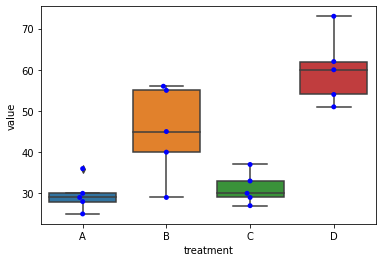

In [57]:
sns.boxplot(x='treatment', y='value', data=df_melt);
sns.swarmplot(x='treatment', y='value', data=df_melt, color='b');

In [66]:
#Condições paramétricas
#2. Normalmente distribuidas

#### Teste de normalidade - Shapiro ####
#H0: Distribuição normalmente distribuida
#H1: Distribução não normal

# if pvalue < alpha:
# print('Rejeito a hipotese nula')
# else
# print('Falha em rejeitar a hipote nula')

stats, pvalue = shapiro(df['A'])
print('p-value - Grupo A: {}'.format(pvalue))
stats, pvalue = shapiro(df['B'])
print('p-value - Grupo B: {}'.format(pvalue))
stats, pvalue = shapiro(df['C'])
print('p-value - Grupo C: {}'.format(pvalue))
stats, pvalue = shapiro(df['D'])
print('p-value - Grupo D: {}'.format(pvalue))

#3. Variancias iguais

print('\nvariancia - Grupo A: {}'.format (np.var(df['A'])))
print('variancia - Grupo B: {}'.format (np.var(df['B'])))
print('variancia - Grupo C: {}'.format (np.var(df['C'])))
print('variancia - Grupo D: {}'.format (np.var(df['D'])))

#Supondo que as VArians foram iguais vamos fazer o ANOVA

p-value - Grupo A: 0.6075581908226013
p-value - Grupo B: 0.5723667740821838
p-value - Grupo C: 0.7583119869232178
p-value - Grupo D: 0.7002365589141846

variancia - Grupo A: 13.040000000000001
variancia - Grupo B: 100.4
variancia - Grupo C: 12.16
variancia - Grupo D: 58.0


In [90]:
stats, pvalue = f_oneway(df['A'],df['B'],df['C'],df['D'])
print('p-value:{}'.format(pvalue))

#h0: Não há diferença na altura média
#h1: Há diferença na altura média

alpha = 0.05
if pvalue < alpha:
    print('Rejeito a hipotese nula')
else:
    print('Falha em rejeitar a hipotese nula(Aceita a hipotese nula)') 

p-value:2.639241146210922e-05
Rejeito a hipotese nula


In [86]:
tukey = pairwise_tukeyhsd(endog= df_melt['value'],groups=df_melt['treatment'],alpha=0.05)
print(tukey)

# Não há evidencia suficiente para dizer que a diferença significativa na altura entre A e C 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     15.4 0.0251   1.694 29.106   True
     A      C      1.6 0.9867 -12.106 15.306  False
     A      D     30.4 0.0001  16.694 44.106   True
     B      C    -13.8 0.0482 -27.506 -0.094   True
     B      D     15.0 0.0296   1.294 28.706   True
     C      D     28.8 0.0001  15.094 42.506   True
---------------------------------------------------
